# Final Project: Online Retail Data Anaysis
Description: This project is to analyse the Transaction Level Retail Data for the customers and recommend additional products for the customers
    
    
Author: Rajesh Kumar
Date: 12/16/2017

# Basic Data Loading


In [1]:
# NumPy for numerical computing
import numpy as np #linear algebra
# Pandas for DataFrames
import pandas as pd #data processing
# Matplotlib for visualization
import matplotlib.pyplot as plt
# Seaborn for easier visualization
import seaborn as sns

#sklearn to do item-item clusterring 
from sklearn import metrics
from sklearn.cluster import KMeans


In [2]:
##
# Read the CSV File
##

data = pd.read_csv('onlineretaildata.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [3]:
##
# Data Needs Cleanup
##

#data1 = data.loc[data['CustomerID'] != np.NaN & data['Quantity'].astype('int64') > 0 & data['StockCode'].astype(str).str.isdigit()]

# Cleanup data where there is no customer id associated
data1 = data.loc[data['CustomerID'] != np.NaN]

# Cleanup data where country is not UK
#data1 = data1.loc[data1.Country == 'United Kingdom']

# Cleanup data where quantity is negative for returns
data1 = data1.loc[data1.Quantity > 0]

# Cleanup data where Item is invalid
data1 = data1.loc[data1.StockCode != 'POST']
data1 = data1.loc[data1.StockCode != '85123A']
data1 = data1.loc[data1.StockCode != '85099B']
data1 = data1.loc[data1.StockCode != '82494L']
data1 = data1.loc[data1.StockCode != '85099B']
data1 = data1.loc[data1.StockCode != '84029G']
data1 = data1.loc[data1.StockCode != '85099C']
data1 = data1.loc[data1.StockCode != '85099F']
data1 = data1.loc[data1.StockCode != 'DOT']

#data1 = data1.loc[data1.CustomerID.dropna()]

# Compute the total value for each item in each transactions
data1["ItemPrice"] = data1["UnitPrice"] * data1["Quantity"]

# Drop unneccessary columns from the data
data1 = data1.drop(columns=["Description", "Country", "InvoiceDate", "InvoiceNo", "UnitPrice", "Quantity"])



#data1 = data1.loc(data1.StockCode.str.isdigit())
data1.info()


# Dump clean data to excel for a quick checkup
data1.to_csv("onlinedatatestdump.csv")
data1.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521895 entries, 1 to 541908
Data columns (total 3 columns):
StockCode     521895 non-null object
CustomerID    390687 non-null float64
ItemPrice     521895 non-null float64
dtypes: float64(2), object(1)
memory usage: 15.9+ MB


,StockCode,CustomerID,ItemPrice
1,71053,17850.0,20.34
2,84406B,17850.0,22.00
4,84029E,17850.0,20.34


In [4]:
## 
# Find top n items as our analysis needs to focus only on these 
##

print data1['StockCode'].agg(['count'])
print data1['CustomerID'].agg(['count'])

# Group by Items and count the total times these appear in data1 dataframe
topitems = data1.groupby(['StockCode']).size().reset_index(name='counts')

#save saved soted values
topitems = topitems.sort_values(['counts'], ascending=[False])

# Values dumps a NP array
topitems = topitems['StockCode'].head(100).values
topitems

count    521895
Name: StockCode, dtype: int64
count    390687
Name: CustomerID, dtype: int64


array(['22423', '47566', '20725', '84879', '22197', '22720', '21212',
       '20727', '22383', '22457', '23203', '22386', '22469', '22086',
       '21931', '22411', '22382', '20728', '22961', '23298', '22960',
       '22666', '23209', '22384', '82482', '22993', '22699', '22727',
       '23206', '20724', '23084', '22178', '22697', '20726', '21080',
       '22726', '23199', '22077', '22139', '21034', '22138', '22470',
       '21790', '23301', '84946', '22629', '23201', '20914', '22355',
       '23202', '21977', '23245', '22112', '21929', '22630', '21181',
       '20712', '84991', '21731', '22722', '20719', '21232', '22910',
       '21175', '21928', '22090', '23355', '21754', '22698', '22728',
       '22111', '22558', '23300', '23207', '22356', '21733', '22379',
       '22326', '23284', '84978', '21166', '22659', '23344', '22624',
       '20723', '22554', '21930', '22907', '20685', '22467', '84380',
       '22385', '22662', '84378', '22551', '22966', '23208', '82484',
       '85152', '212

# Data Analysis

In [5]:
## Find all customers who bought top 100 items
# Number of times top 100 items were bought by the customers
# Number of customers who bought 100 iems
##

print data1.loc[data1.StockCode.isin(topitems)].size

customeritemdf = data1.loc[data1.StockCode.isin(topitems)]

uniqueVals = customeritemdf["CustomerID"].unique()

#Print unique values for the data
print uniqueVals.size


287466
3919


In [6]:
## Reduce dataframe to only have top n items
data1 = data1.loc[data1.StockCode.isin(topitems)]
data1.info()
data1.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 95822 entries, 9 to 541908
Data columns (total 3 columns):
StockCode     95822 non-null object
CustomerID    76434 non-null float64
ItemPrice     95822 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.9+ MB


,StockCode,CustomerID,ItemPrice
9,84879,13047.0,54.08
17,21754,13047.0,17.85
21,22960,13047.0,25.50
26,22728,12583.0,90.00
27,22727,12583.0,90.00


In [7]:
## Group by Customers and Items for Total price spent by customer
aggregatedf = []
aggregatedf = data1.groupby(['CustomerID', 'StockCode']).agg(['sum'])
aggregatedf.reset_index('CustomerID')
aggregatedf.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 39640 entries, (12347.0, 20719) to (18287.0, 21232)
Data columns (total 1 columns):
(ItemPrice, sum)    39640 non-null float64
dtypes: float64(1)
memory usage: 457.3+ KB


In [8]:
aggregatedf.head(10)

ItemPrice
                           sum
CustomerID StockCode          
12347.0    20719         34.00
           21731        118.80
           22423        191.25
           22697         35.40
           22698         35.40
           22699         70.80
           22726         60.00
           22727        135.00
           22728         60.00
           23084        153.84

In [9]:
dataunstack = aggregatedf.unstack()
dataunstack.to_csv('UnstackedData2.csv')
#dataunstack.info()
dataunstack.head(10)

#dataunstack = aggregatedf.reset_index().pivot(columns='StockCode', index='CustomerID', values='ItemPrices')

ItemPrice                                                        \
                 sum                                                         
StockCode      20685 20712 20719 20723 20724 20725 20726 20727 20728 20914   
CustomerID                                                                   
12347.0          NaN   NaN  34.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
12348.0          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
12349.0         49.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  17.7   
12350.0          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
12352.0          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
12354.0          NaN   NaN   NaN   NaN   NaN  16.5   NaN   NaN   NaN   NaN   
12355.0          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
12356.0          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
12357.0          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
12358.0          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

            ...                                                                
            ...                                                                
StockCode   ...  47566 82482 82484  84378 84380 84879 84946 84978 84991 85152  
CustomerID  ...                                                                
12347.0     ...    NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN  39.6   NaN  
12348.0     ...    NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN  63.6   NaN  
12349.0     ...    NaN   NaN   NaN    NaN   NaN   NaN   NaN  15.0   NaN   NaN  
12350.0     ...    NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN  
12352.0     ...    NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN  
12354.0     ...    NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN  
12355.0     ...    NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN  
12356.0     ...    NaN   NaN   NaN  63.75  30.0   NaN   NaN   NaN  76.8   NaN  
12357.0     ...    NaN   NaN   NaN  17.40   NaN   NaN   NaN   NaN   NaN   NaN  
12358.0     ...    NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[10 rows x 100 columns]

In [10]:
#remove Nan
dataready = dataunstack.fillna(0)
print dataready.index.size
dataready.head(10)


3918


ItemPrice                                                        \
                 sum                                                         
StockCode      20685 20712 20719 20723 20724 20725 20726 20727 20728 20914   
CustomerID                                                                   
12347.0          0.0   0.0  34.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
12348.0          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
12349.0         49.5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  17.7   
12350.0          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
12352.0          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
12354.0          0.0   0.0   0.0   0.0   0.0  16.5   0.0   0.0   0.0   0.0   
12355.0          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
12356.0          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
12357.0          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
12358.0          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

            ...                                                                
            ...                                                                
StockCode   ...  47566 82482 82484  84378 84380 84879 84946 84978 84991 85152  
CustomerID  ...                                                                
12347.0     ...    0.0   0.0   0.0   0.00   0.0   0.0   0.0   0.0  39.6   0.0  
12348.0     ...    0.0   0.0   0.0   0.00   0.0   0.0   0.0   0.0  63.6   0.0  
12349.0     ...    0.0   0.0   0.0   0.00   0.0   0.0   0.0  15.0   0.0   0.0  
12350.0     ...    0.0   0.0   0.0   0.00   0.0   0.0   0.0   0.0   0.0   0.0  
12352.0     ...    0.0   0.0   0.0   0.00   0.0   0.0   0.0   0.0   0.0   0.0  
12354.0     ...    0.0   0.0   0.0   0.00   0.0   0.0   0.0   0.0   0.0   0.0  
12355.0     ...    0.0   0.0   0.0   0.00   0.0   0.0   0.0   0.0   0.0   0.0  
12356.0     ...    0.0   0.0   0.0  63.75  30.0   0.0   0.0   0.0  76.8   0.0  
12357.0     ...    0.0   0.0   0.0  17.40   0.0   0.0   0.0   0.0   0.0   0.0  
12358.0     ...    0.0   0.0   0.0   0.00   0.0   0.0   0.0   0.0   0.0   0.0  

[10 rows x 100 columns]

In [11]:
dataready.values


array([[  0.  ,   0.  ,  34.  , ...,   0.  ,  39.6 ,   0.  ],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,  63.6 ,   0.  ],
       [ 49.5 ,   0.  ,   0.  , ...,  15.  ,   0.  ,   0.  ],
       ..., 
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  ,  26.78,  14.45, ...,   0.  ,   3.85,   2.1 ],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]])

In [12]:
##
# Code snippet for analysis
#  
##

customeritem = []
#z = 5

customeritem = [dataready.index[0]]

for x in dataready.index:
    #z -=1

    #if z>0:
        #print x
        #print dataready.loc[dataready.index == x]
    customeritem.append(x)
print len(customeritem)
customeritem = set(customeritem)
print len(customeritem)
        #customeritem.append(dataready.loc[dataready.index == x])
print customeritem


3919
3918
set([16384.0, 16385.0, 16386.0, 16387.0, 16389.0, 16392.0, 16393.0, 16394.0, 16395.0, 16398.0, 16399.0, 16400.0, 16401.0, 16402.0, 16403.0, 16404.0, 16406.0, 16407.0, 16409.0, 16411.0, 16412.0, 16413.0, 16414.0, 16415.0, 16416.0, 16418.0, 16419.0, 16422.0, 16423.0, 16424.0, 16425.0, 16426.0, 16427.0, 16430.0, 16431.0, 16432.0, 16433.0, 16434.0, 16438.0, 16440.0, 16441.0, 16442.0, 16444.0, 16445.0, 16447.0, 16449.0, 16450.0, 16451.0, 16455.0, 16456.0, 16457.0, 16458.0, 16460.0, 16463.0, 16464.0, 16466.0, 16468.0, 16469.0, 16470.0, 16471.0, 16473.0, 16474.0, 16475.0, 16477.0, 16478.0, 16479.0, 16480.0, 16482.0, 16483.0, 16484.0, 16485.0, 16488.0, 16491.0, 16493.0, 16494.0, 16495.0, 16496.0, 16497.0, 16498.0, 16499.0, 16500.0, 16503.0, 16504.0, 16506.0, 16509.0, 16510.0, 16511.0, 16513.0, 16515.0, 16516.0, 16517.0, 16518.0, 16519.0, 16520.0, 16523.0, 16525.0, 16527.0, 16529.0, 16531.0, 16533.0, 16535.0, 16536.0, 16539.0, 16545.0, 16546.0, 16549.0, 16550.0, 16551.0, 16552.0, 1655

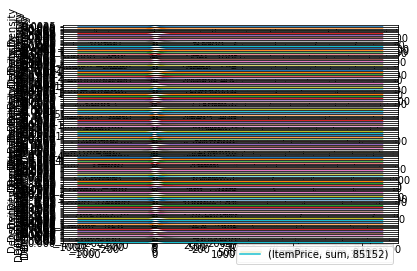

In [13]:
#data1.StockCode.unique()
dataunstack.plot(kind="density", subplots=True, sharex=False)
plt.show()

In [14]:
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans

sample_df_train, sample_df_test = train_test_split(dataready, train_size=0.8)

#print sample_df_test
cluster = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)
cluster.fit(sample_df_train)
result = cluster.predict(sample_df_test)
print result.size
print set(result)



C:\Users\User\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


784
set([0, 2])


In [15]:
from sklearn.cross_validation import train_test_split

sample_df_train, sample_df_test = train_test_split(dataready, train_size=0.8)

#print sample_df_test
cluster = KMeans(n_clusters=8, init='k-means++', n_init=5, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)
#cluster.fit(sample_df_train)
cluster.fit(dataready)
result = cluster.predict(dataready)
print result.size
result

3918


array([0, 0, 0, ..., 0, 0, 0])

In [16]:
set(result)

{0, 1, 2, 3, 4, 5, 6, 7}

In [17]:
## Add the Cluster number along with the data frame
dataready['ClusterID'] = result
dataready.head(3)

ItemPrice                                                        \
                 sum                                                         
StockCode      20685 20712 20719 20723 20724 20725 20726 20727 20728 20914   
CustomerID                                                                   
12347.0          0.0   0.0  34.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
12348.0          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
12349.0         49.5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  17.7   

              ...                                                           \
              ...                                                            
StockCode     ...    82482 82484 84378 84380 84879 84946 84978 84991 85152   
CustomerID    ...                                                            
12347.0       ...      0.0   0.0   0.0   0.0   0.0   0.0   0.0  39.6   0.0   
12348.0       ...      0.0   0.0   0.0   0.0   0.0   0.0   0.0  63.6   0.0   
12349.0       ...      0.0   0.0   0.0   0.0   0.0   0.0  15.0   0.0   0.0   

           ClusterID  
                      
StockCode             
CustomerID            
12347.0            0  
12348.0            0  
12349.0            0  

[3 rows x 101 columns]

In [20]:
import numpy as np
from sklearn.manifold import TSNE
X = dataready.values
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(3918L, 2L)

In [53]:
##
# Try to do PCA on the data
##
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca_result = pca.fit_transform(dataready[ClusterID].values)

dataready['pca-one'] = pca_result[:,0]
dataready['pca-two'] = pca_result[:,1] 
dataready['pca-three'] = pca_result[:,2]


NameError: name 'ClusterID' is not defined

In [42]:
##
# Put the values in NP Array for creating visualizations
##
npdisplaydata = dataready.values

In [43]:
from sklearn.manifold import TSNE
X = npdisplaydata
X_embedded = TSNE(n_components=2).fit_transform(X)


In [48]:
X_embedded.shape

(3918L, 2L)

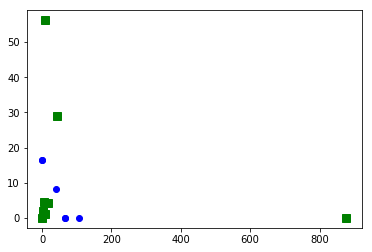

In [78]:
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq

# data generation
#data = vstack((rand(150,2) + array([.5,.5]),rand(150,2)))

# computing K-Means with K = 2 (2 clusters)
centroids,_ = kmeans(npdisplaydata,8)
# assign each sample to a cluster
idx,_ = vq(npdisplaydata,centroids)

# some plotting using numpy's logical indexing
plot(npdisplaydata[idx==0,0],npdisplaydata[idx==0,1],'ob',
     npdisplaydata[idx==1,0],npdisplaydata[idx==1,1],'or')
plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 10
#for customer in dataready

data = np.random.random((N, 4))
labels = ['point{0}'.format(i) for i in range(N)]

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    data[:, 0], data[:, 1], marker='o', c=data[:, 2], s=data[:, 3] * 1500,
    cmap=plt.get_cmap('Spectral'))

for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import mlab
import Pycluster as pc

# make fake user data
users = np.random.normal(0, 10, (20, 5))

# cluster
clusterid, error, nfound = pc.kcluster(dataready, nclusters=8, transpose=0, 
                                       npass=10, method='a', dist='e')
centroids, _ = pc.clustercentroids(dataready, clusterid=clusterid)

# reduce dimensionality
users_pca = mlab.PCA(dataready)
cutoff = users_pca.fracs[1]
users_2d = users_pca.project(dataready, minfrac=cutoff)
centroids_2d = users_pca.project(centroids, minfrac=cutoff)

# make a plot
colors = ['red', 'green', 'blue']
plt.figure()
plt.xlim([users_2d[:,0].min() - .5, users_2d[:,0].max() + .5])
plt.ylim([users_2d[:,1].min() - .5, users_2d[:,1].max() + .5])
plt.xticks([], []); plt.yticks([], []) # numbers aren't meaningful

# show the centroids
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], marker='o', c=colors, s=100)

# show user numbers, colored by their cluster id
for i, ((x,y), kls) in enumerate(zip(users_2d, clusterid)):
    plt.annotate(str(i), xy=(x,y), xytext=(0,0), textcoords='offset points',
                 color=colors[kls])

In [2]:
from skdata.mnist.views import OfficialImageClassification

In [2]:
from skdata.mnist.views import OfficialImageClassification
from matplotlib import pyplot as plt
from tsne import bh_sne

# load up data
data = OfficialImageClassification(x_dtype="float32")
x_data = data.all_images
y_data = data.all_labels

# convert image data to float64 matrix. float64 is need for bh_sne
x_data = np.asarray(x_data).astype('float64')
x_data = x_data.reshape((x_data.shape[0], -1))

# For speed of computation, only run on a subset
n = 20000
x_data = x_data[:n]
y_data = y_data[:n]

# perform t-SNE embedding
vis_data = bh_sne(x_data)

# plot the result
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]

plt.scatter(vis_x, vis_y, c=y_data, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

ImportError: No module named skdata.mnist.views

# Train and Test split

# Cluster Analysis